In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [182]:
def dphi(x):
    f1=1/np.sqrt(2*np.pi*2)*np.exp(-(x-0)*(x-0)/2)
    f2=1/np.sqrt(2*np.pi*6)*np.exp(-(x-7)*(x-7)/6)
    f3=1/np.sqrt(2*np.pi*3)*np.exp(-(x-12)*(x-12)/3)
    return f1+f2+f3

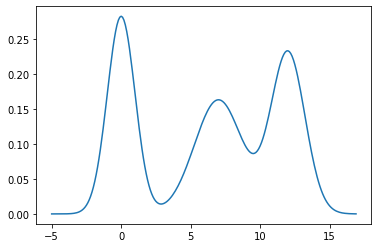

In [184]:
x=np.arange(-5,17,0.1)
y=dphi(x)
plt.plot(x,y)

In [185]:
data1=np.random.uniform(-5,17,5000)
data2=np.random.uniform(-5,17,5000)
p1=np.random.uniform(0,1,5000)
p2=np.random.uniform(0,1,5000)

In [186]:
prob=dphi(data1)
idx=p<=(prob/0.35)
sample1=data1[idx]

In [187]:
prob=dphi(data2)
idx=p<=(prob/0.35)
sample2=data2[idx]

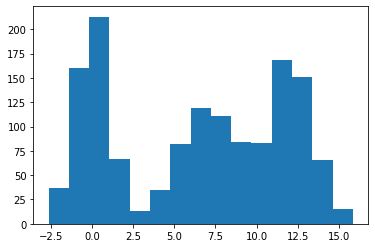

In [188]:
plt.hist(sample1,bins=15)
plt.show()

(-5.0, 17.0)

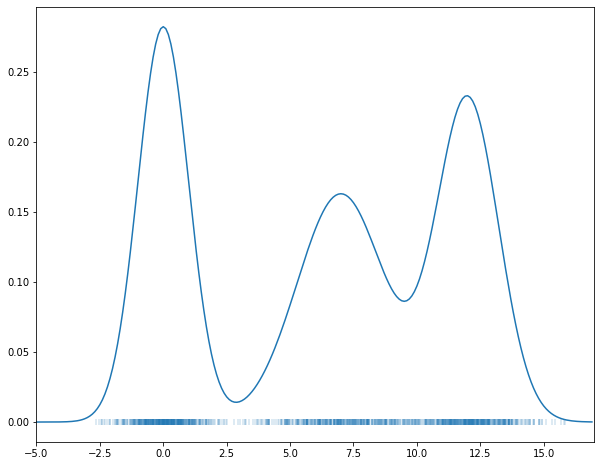

In [189]:
plt.figure(figsize=(10,8))
plt.scatter(sample1,np.zeros(sample1.shape[0]),marker='|',linewidths=0.3)
plt.plot(x,y)
plt.xlim([-5,17])

In [165]:
class Kernel:
    def __init__(self,d,data):
        self.d=d
        self.data=data
    
    def dist(self,x):
        z=x.reshape(-1,1)
        mu=self.data.reshape(1,-1)
        r=self.f(z-mu).sum(1)
        
        return r/z.shape[0]
    
    def le(self,x):
        r=self.dist(x)
        r=-np.log(r).sum()
        
        return r
    
    def f(self,x):
        p=1/np.sqrt(2*np.pi*self.d**2)*np.exp(-(x)*(x)/(self.d**2))
        
        return p

In [190]:
K=Kernel(1,sample1)

In [191]:
xs=np.arange(-5,17,0.1)
dists=[]
les=[]
ds=[0.01,0.1,0.5,1,2,10,15]
for d in ds:
    K.d=d
    dist=K.dist(xs)
    le=K.le(sample2)
    les.append(le)
    dists.append(dist)

/Users/JoaoGomes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [192]:
les

[inf,
 4314.338599060597,
 4264.91449075699,
 4278.186496137552,
 4385.875911466794,
 5035.599641111788,
 5340.453769713211]

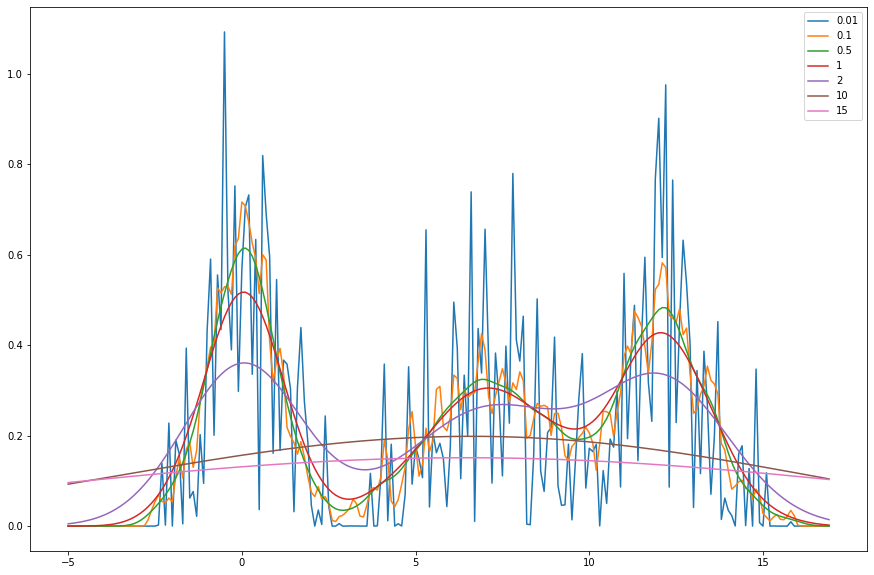

In [193]:
plt.figure(figsize=(15,10))
for dist,d in zip(dists,ds):
    plt.plot(xs,dist)
plt.legend(ds)

# Regression

In [322]:
def f(x):
    y=x*x*np.exp(-0.05*x)
    return y

xtrain=np.arange(0,200)
eps=np.random.normal(0,10,200)
y=f(x)
ytrain=y+eps

xtest=np.random.randint(0,200,50)
ytest=f(xtest)+np.random.normal(0,10,50)

In [350]:
class KernelRg:
    def __init__(self,d):
        self.d=d
        
    def fit(self,x,y):
        self.x=x
        self.y=y
        
    def predict(self,x):
        z=x.reshape(-1,1)
        mu=self.x.reshape(1,-1)
        r=self.f(z-mu)
        r_=r*(self.y.reshape(1,-1))
        r_=r_.sum(1)
        N=r.sum(1)
        return r_/N
    
    def prob(self,x):
        z=x.reshape(-1,1)
        mu=self.x.reshape(1,-1)
        r=self.f(z-mu)
        p=r.sum(1)
        
        return p
    
    def le(self,x):
        p=self.prob(x)
        L=-np.log(p).sum()
        
        return L
        
    def f(self,x):
        p=1/np.sqrt(2*np.pi*self.d**2)*np.exp(-(x)*(x)/(self.d**2))
        
        return p

In [259]:
z=np.arange(0,200,0.2)

In [359]:
K=KernelRg(0.1)
K.fit(xtrain,ytrain)

In [360]:
w=K.predict(z)

In [327]:
ypred=K.predict(xtest)

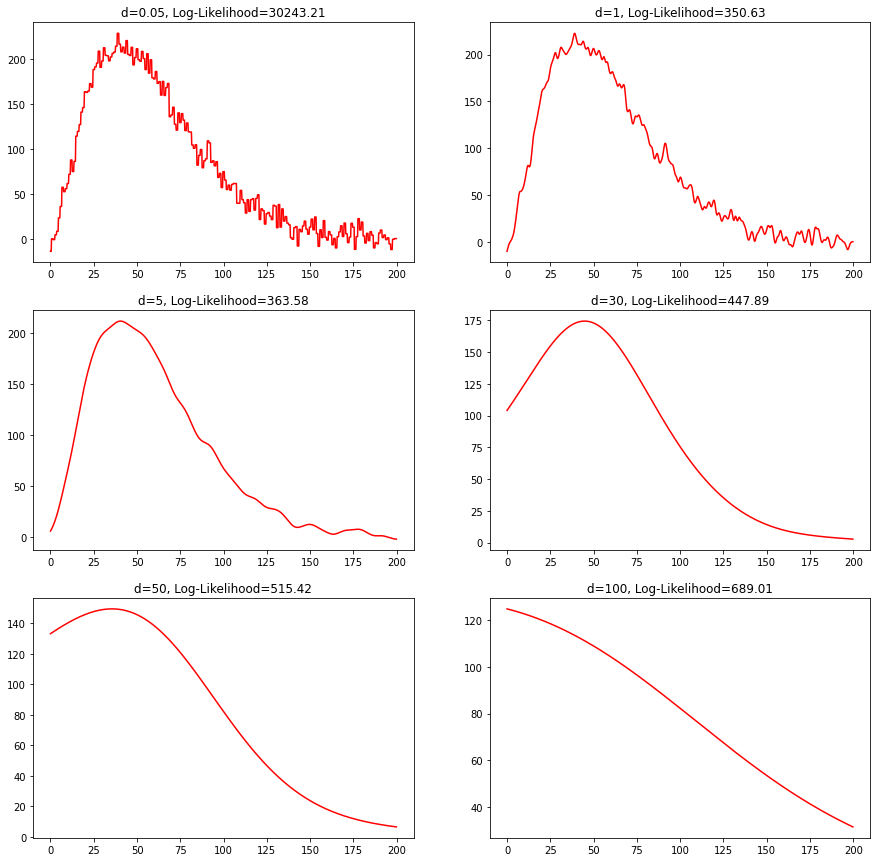

In [364]:
fig, axs =plt.subplots(3,2,figsize=(15,15))
for l,d in enumerate([0.05,1,5,30,50,100]):
    K.d=d
    w=K.predict(z)
    le=K.le(z)
    i=l//2
    j=l%2
    axs[i,j].plot(z,w,color='red')
    axs[i,j].set_title(f'd={d}, Log-Likelihood={np.round(le,2)}')

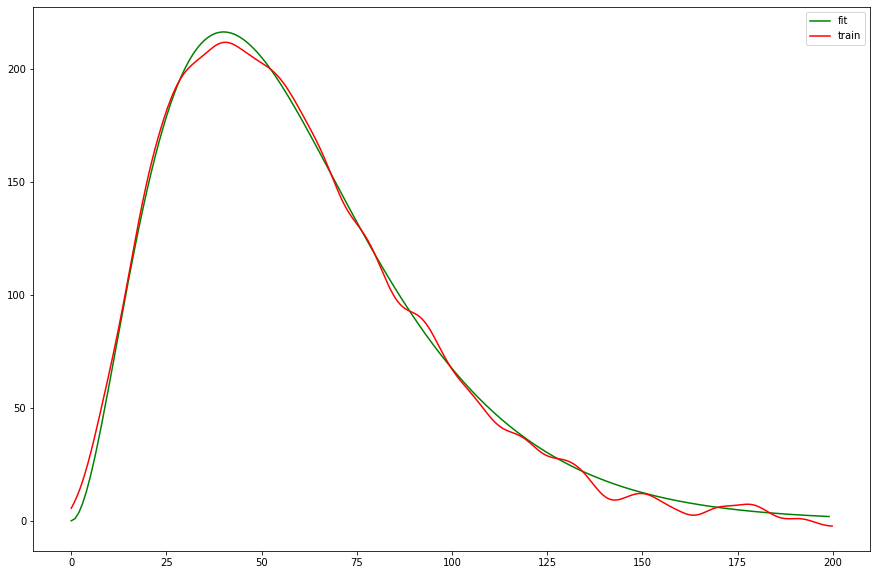

In [331]:
plt.figure(figsize=(15,10))
plt.plot(x,y,color='g')
#plt.scatter(xtrain,ytrain)
plt.plot(z,w,color='red')
plt.legend(['fit','train'])
plt.show()